In [24]:
import pandas as pd # for our dataframe displays and manipulation
import re  
import numpy as np # for our arrays and mathematical computations
import matplotlib.pyplot as plt # for visualization
import seaborn as sns # for advanced visualizations
sns.set(style="darkgrid")
from IPython.display import display # Allows the use of display() for DataFrames
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
import seaborn as sns

In [2]:
# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Display the first few rows of the training dataset to understand its structure
train_df

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,...,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
0,268700,NaN,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,...,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191
1,484983,White,NaN,IL,629,Midwest,East North Central,55,F,35.36,...,49.30,72.87,77.40,77.43,75.83,72.64,58.36,39.68,39.71,33
2,277055,NaN,COMMERCIAL,CA,925,West,Pacific,59,F,NaN,...,68.50,70.31,78.61,87.24,85.52,80.75,70.81,62.67,55.58,157
3,320055,Hispanic,MEDICAID,CA,900,West,Pacific,59,F,NaN,...,63.34,63.10,67.45,75.86,75.24,71.10,68.95,65.46,59.46,146
4,190386,NaN,COMMERCIAL,CA,934,West,Pacific,71,F,NaN,...,59.45,60.24,64.77,69.81,70.13,68.10,65.38,60.72,54.08,286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13168,588544,Hispanic,MEDICAID,PA,191,Northeast,Middle Atlantic,59,F,NaN,...,48.81,66.12,70.38,77.18,77.53,70.90,56.53,41.46,37.49,106
13169,393047,NaN,COMMERCIAL,TX,757,South,West South Central,73,F,30.67,...,62.03,77.82,84.52,85.35,84.61,78.50,67.24,52.16,50.01,92
13170,790904,NaN,COMMERCIAL,CA,928,West,Pacific,19,F,NaN,...,66.20,66.04,70.87,80.68,79.75,75.27,71.40,66.01,59.20,0
13171,455518,NaN,COMMERCIAL,MI,481,Midwest,East North Central,52,F,NaN,...,39.93,63.56,68.68,72.13,72.55,66.17,49.79,34.16,32.28,330


In [3]:
print(train_df.dtypes)

# Separate columns into categorical and numerical
categorical_columns = train_df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
numerical_columns = train_df.select_dtypes(include=['number']).columns.tolist()

print("Categorical columns:", categorical_columns)
print("Numerical columns:", numerical_columns)

patient_id                       int64
patient_race                    object
payer_type                      object
patient_state                   object
patient_zip3                     int64
                                ...   
Average of Sep-18              float64
Average of Oct-18              float64
Average of Nov-18              float64
Average of Dec-18              float64
metastatic_diagnosis_period      int64
Length: 152, dtype: object
Categorical columns: ['patient_race', 'payer_type', 'patient_state', 'Region', 'Division', 'patient_gender', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']
Numerical columns: ['patient_id', 'patient_zip3', 'patient_age', 'bmi', 'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_over_80', 'male', 'female', 'married', 'divo

In [4]:
# Check data types and count missing values
data_info = train_df.info()
missing_values = train_df.isnull().sum()

missing_values_summary = pd.DataFrame({
    'column': train_df.columns,
    'missing_count': missing_values,
    'missing_percentage': (missing_values / len(train_df)) * 100
})

missing_values_summary_sorted = missing_values_summary.sort_values(by='missing_percentage', ascending=False)

# Display data info and missing values summary
data_info, missing_values_summary_sorted.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13173 entries, 0 to 13172
Columns: 152 entries, patient_id to metastatic_diagnosis_period
dtypes: float64(137), int64(4), object(11)
memory usage: 15.3+ MB


(None,
                                                                       column  \
 metastatic_first_novel_treatment_type  metastatic_first_novel_treatment_type   
 metastatic_first_novel_treatment            metastatic_first_novel_treatment   
 bmi                                                                      bmi   
 patient_race                                                    patient_race   
 payer_type                                                        payer_type   
 Average of Apr-14                                          Average of Apr-14   
 Average of Jun-14                                          Average of Jun-14   
 Average of Oct-13                                          Average of Oct-13   
 Average of Jul-18                                          Average of Jul-18   
 Average of Dec-18                                          Average of Dec-18   
 Average of Jan-13                                          Average of Jan-13   
 Average of Jul-17   

In [5]:
# Generate summary statistics for numerical features
numerical_summary = train_df.describe()

# Display the summary statistics
numerical_summary

,patient_id,patient_zip3,patient_age,bmi,population,density,age_median,age_under_10,age_10_to_19,age_20s,...,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
count,13173.000000,13173.000000,13173.000000,4102.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,...,13173.000000,13173.000000,13164.000000,13127.000000,13157.000000,13166.000000,13166.000000,13161.000000,13140.000000,13173.000000
mean,555441.784939,568.530859,59.271313,29.168808,20651.373928,1776.872376,40.542676,11.104988,12.857587,13.297375,...,52.411982,67.932236,73.074635,77.120929,76.281156,71.417027,59.323286,46.100150,42.096213,96.515221
std,259476.503094,275.758485,13.218883,5.752820,13840.379638,3876.061897,4.031027,1.511534,1.952248,3.390472,...,11.069900,6.301740,6.581630,5.335091,5.282156,6.502875,9.261934,12.245594,11.209011,108.969873
min,100043.000000,100.000000,18.000000,15.000000,635.550000,0.920000,20.600000,0.000000,6.310000,5.930000,...,28.790000,45.880000,53.460000,58.540000,56.200000,51.830000,37.540000,19.150000,15.380000,0.000000
25%,335100.000000,330.000000,50.000000,24.825000,9160.340000,163.150000,37.190000,10.150000,11.650000,11.000000,...,42.900000,63.220000,68.050000,73.170000,72.550000,67.020000,51.970000,35.560000,33.370000,3.000000
50%,555769.000000,557.000000,59.000000,28.580000,18952.780000,700.340000,40.640000,11.000000,12.900000,12.530000,...,50.290000,66.120000,71.640000,76.650000,76.080000,70.880000,57.450000,42.430000,38.500000,44.000000
75%,780967.000000,832.000000,67.000000,33.000000,30021.280000,1666.520000,42.940000,12.140000,13.910000,14.970000,...,62.220000,72.590000,77.660000,80.290000,79.130000,75.640000,67.360000,55.730000,50.500000,181.000000
max,999982.000000,995.000000,91.000000,97.000000,71374.130000,29851.690000,54.570000,17.680000,35.300000,62.100000,...,76.490000,86.570000,90.660000,96.430000,95.770000,89.190000,81.460000,76.300000,73.540000,365.000000


In [6]:
# Drop columns with nearly 100% missing values
columns_to_drop = ['metastatic_first_novel_treatment_type', 'metastatic_first_novel_treatment']
train_df_cleaned = train_df.drop(columns=columns_to_drop)

# Handle missing values for other important columns
# Impute missing BMI values with the median BMI
train_df_cleaned['bmi'] = train_df_cleaned['bmi'].fillna(train_df_cleaned['bmi'].median())

# For patient_race, we can create a new category 'Unknown' for missing values
train_df_cleaned['patient_race'] = train_df_cleaned['patient_race'].fillna('Unknown')

# For payer_type, create a new category 'Unknown' for missing values
train_df_cleaned['payer_type'] = train_df_cleaned['payer_type'].fillna('Unknown')

# Verify the changes
missing_values_after_cleaning = train_df_cleaned.isnull().sum().sort_values(ascending=False)
missing_values_after_cleaning.head(20)

Average of Apr-14    180
Average of Jun-14    152
Average of Oct-13     59
Average of Jul-18     46
Average of Jan-13     33
Average of Dec-18     33
Average of Jul-17     31
Average of Mar-14     29
Average of Apr-15     28
Average of Sep-13     27
Average of Nov-14     24
Average of Aug-15     22
Average of Oct-17     21
Average of Jun-13     20
Average of May-16     19
Average of Dec-15     18
Average of Aug-13     17
Average of Oct-15     16
Average of Nov-15     16
Average of Jan-16     16
dtype: int64

In [7]:
# Analyze the distribution of categorical features

# List of categorical features to analyze
categorical_features = ['patient_race', 'payer_type', 'patient_state', 'Region', 'Division', 'patient_gender']

# Function to get the value counts for each categorical feature
categorical_distributions = {feature: train_df_cleaned[feature].value_counts() for feature in categorical_features}

# Display the value counts for each categorical feature
categorical_distributions

{'patient_race': patient_race
 Unknown     6657
 White       3565
 Black       1159
 Hispanic     807
 Other        612
 Asian        373
 Name: count, dtype: int64,
 'payer_type': payer_type
 COMMERCIAL            6297
 MEDICAID              2593
 MEDICARE ADVANTAGE    2518
 Unknown               1765
 Name: count, dtype: int64,
 'patient_state': patient_state
 CA    2377
 NY    1189
 TX    1139
 IL     871
 MI     854
 OH     750
 FL     587
 GA     562
 PA     532
 VA     370
 MN     366
 CO     364
 IN     315
 KY     282
 AZ     243
 WI     220
 NC     202
 WA     197
 MO     167
 LA     148
 NM     139
 OK     130
 SC     119
 TN     119
 ID     113
 OR      93
 IA      88
 AR      81
 NV      70
 KS      65
 MD      64
 MT      63
 MS      63
 NE      52
 UT      31
 AL      30
 WV      30
 HI      24
 DE      19
 DC      15
 SD      14
 AK       7
 WY       5
 ND       4
 Name: count, dtype: int64,
 'Region': Region
 South        3960
 Midwest      3766
 West         3726
 Nort

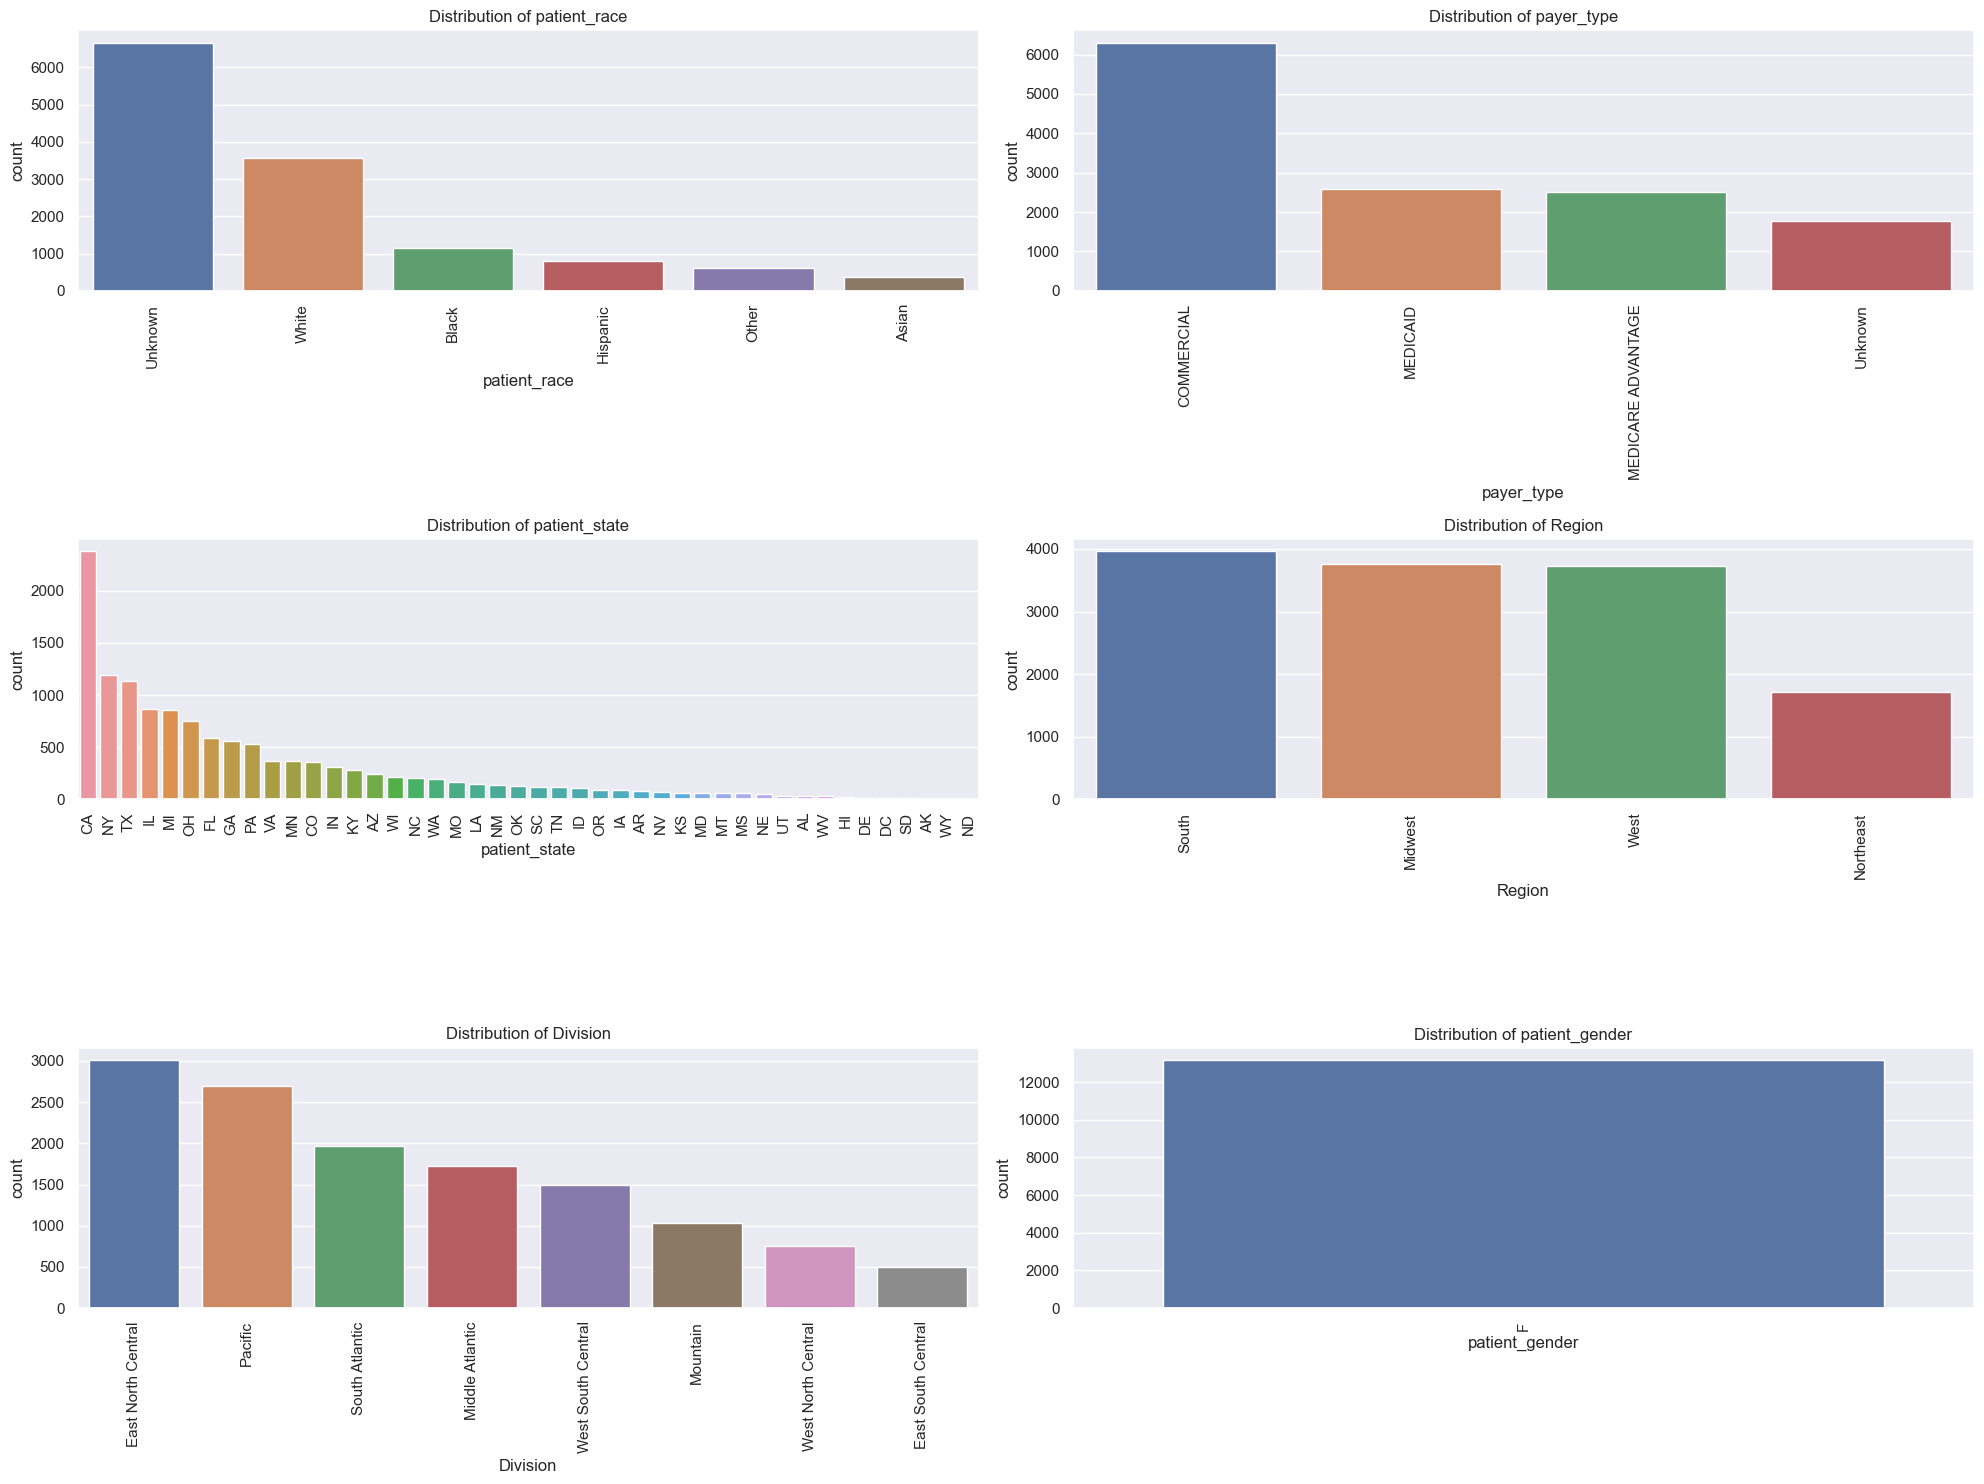

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# Plot distributions of key categorical features
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=train_df_cleaned, x=feature, order=train_df_cleaned[feature].value_counts().index)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

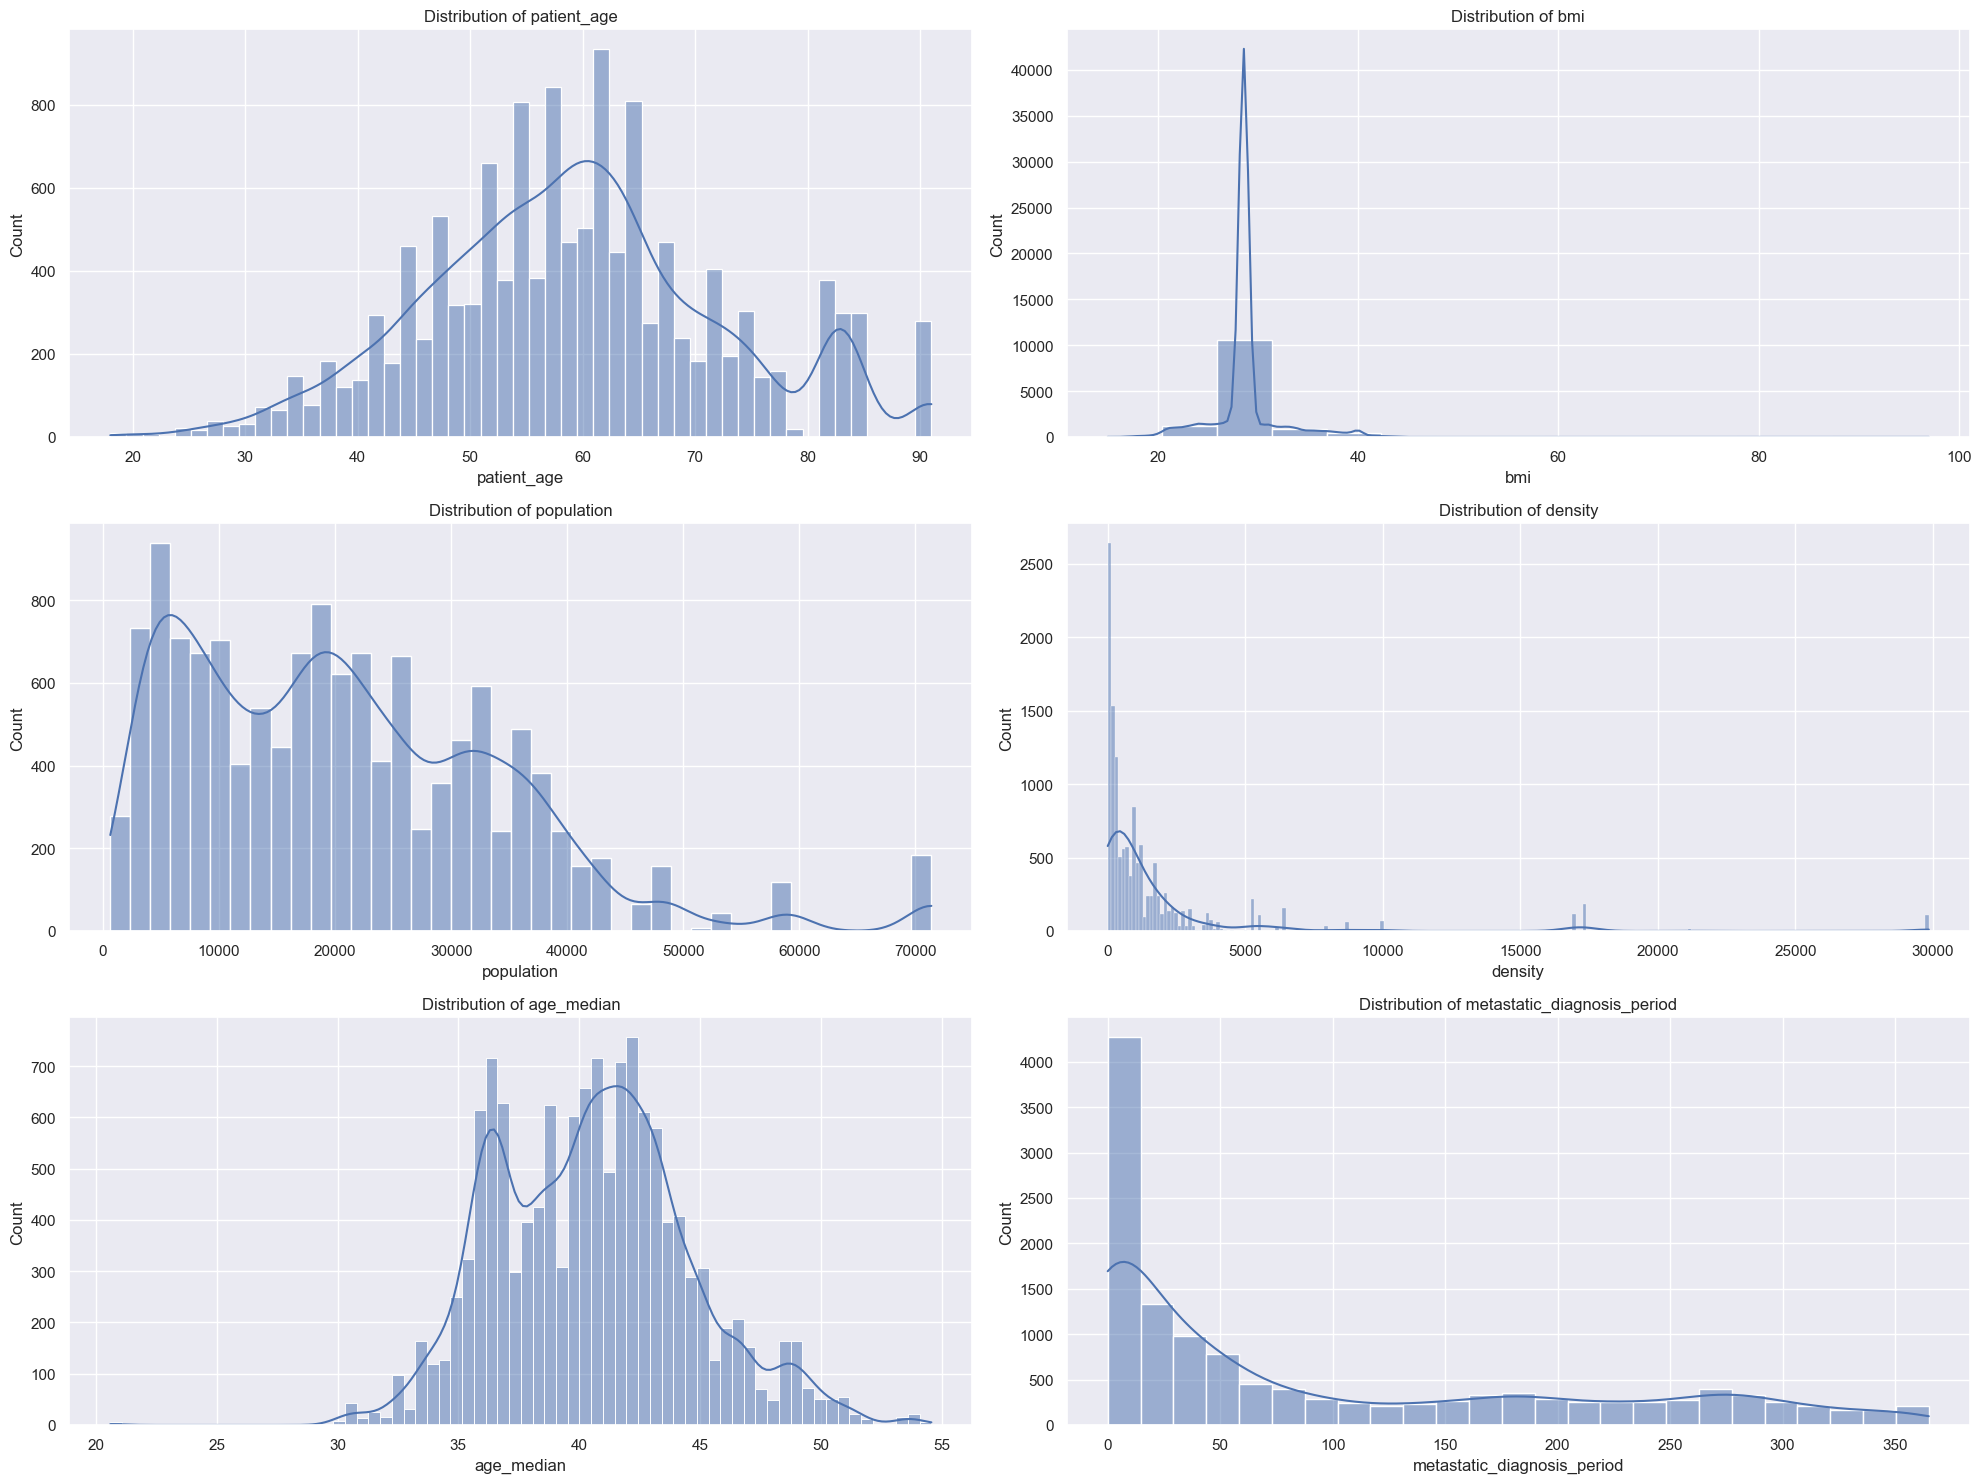

In [9]:
# Visualize the distribution of key numerical features
plt.figure(figsize=(20, 15))

# List of numerical features to visualize
numerical_features = ['patient_age', 'bmi', 'population', 'density', 'age_median', 'metastatic_diagnosis_period']

# Plot distributions of numerical features
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(train_df_cleaned[feature], kde=True)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

In [10]:
# Ensure all columns are numeric
numeric_df = train_df_cleaned.select_dtypes(include=[float, int])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Display the correlation with the target variable
target_variable = 'metastatic_diagnosis_period'
correlation_with_target = correlation_matrix[target_variable].sort_values(ascending=False)

# Display the correlation with the target variable
print(correlation_with_target)

metastatic_diagnosis_period    1.000000
income_household_10_to_15      0.031975
Average of May-15              0.029484
poverty                        0.029135
widowed                        0.029086
                                 ...   
patient_zip3                  -0.028686
education_bachelors           -0.033842
family_dual_income            -0.036403
labor_force_participation     -0.039369
patient_age                   -0.055231
Name: metastatic_diagnosis_period, Length: 141, dtype: float64


In [11]:
# Feature Engineering
# Example: Creating new features based on existing ones

# Interaction term between patient_age and bmi
train_df_cleaned['age_bmi_interaction'] = train_df_cleaned['patient_age'] * train_df_cleaned['bmi']

# Calculate the average temperature for the given climate columns
climate_columns = [col for col in train_df_cleaned.columns if 'Average of' in col]
train_df_cleaned['average_temperature'] = train_df_cleaned[climate_columns].mean(axis=1)

# Verify the new features
train_df_cleaned[['patient_age', 'bmi', 'age_bmi_interaction', 'average_temperature']].head()

,patient_age,bmi,age_bmi_interaction,average_temperature
0,39,28.58,1114.62,59.083750
1,55,35.36,1944.80,56.399028
2,59,28.58,1686.22,70.011250
3,59,28.58,1686.22,66.694861
4,71,28.58,2029.18,61.847361


In [12]:
from sklearn.model_selection import train_test_split

# Define the features and target variable
features = train_df_cleaned.drop(columns=['metastatic_diagnosis_period', 'patient_id'])
target = train_df_cleaned['metastatic_diagnosis_period']

# Perform train-test split
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# Verify the shape of the splits
(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

((10538, 150), (2635, 150), (10538,), (2635,))

In [26]:
target.head()

0    191
1     33
2    157
3    146
4    286
Name: metastatic_diagnosis_period, dtype: int64

In [28]:
target_mean= target.mean()
target_pred_baseline = [target_mean] * len(features)
target_pred_baseline

[96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.5152205268352,
 96.51522052

In [32]:
model = make_pipeline(
    OneHotEncoder(handle_unknown= "ignore"),
    Ridge()
)
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('ridge', Ridge())])

In [34]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

82.98676069254279

In [37]:
# Prepare the submission file using the Linear Regression model

# Load the test dataset and preprocess similarly
test_df_cleaned_2= pd.get_dummies(test_df, drop_first=True)
test_df_cleaned_2= test_df_cleaned.reindex(columns=X_train_encoded.columns, fill_value=0)
test_df_cleaned_imputed_2= imputer.transform(test_df_cleaned_2)

# Predict on the test dataset using the trained Linear Regression model
test_predictions_2 = forest_model.predict(test_df_cleaned_imputed_2)

# Prepare the submission DataFrame
submission_df = pd.DataFrame({
    'patient_id': test_df['patient_id'],
    'metastatic_diagnosis_period': test_predictions_2
})
# Ensure the metastatic_diagnosis_period is in integer format
submission_df['metastatic_diagnosis_period'] = submission_df['metastatic_diagnosis_period'].round().astype(int)

# Save the submission DataFrame to a CSV file
submission_file_path = 'submission_2.csv'
submission_df.to_csv(submission_file_path, index=False)

# Display the first few rows of the submission file
submission_df.head()

,patient_id,metastatic_diagnosis_period
0,730681,165
1,334212,113
2,571362,205
3,907331,207
4,208382,90


In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the validation set
y_pred = linear_model.predict(X_val)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Display RMSE
rmse

ValueError: could not convert string to float: 'White'

In [18]:
# One-hot encode the categorical features
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_val_encoded = pd.get_dummies(X_val, drop_first=True)

# Align the columns of validation set to match the training set
X_val_encoded = X_val_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Train a Linear Regression model on the encoded data
linear_model = LinearRegression()
linear_model.fit(X_train_encoded, y_train)

# Predict on the validation set
y_pred = linear_model.predict(X_val_encoded)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Display RMSE
rmse

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [19]:
from sklearn.impute import SimpleImputer

# Impute remaining missing values with the median for numerical features
imputer = SimpleImputer(strategy='median')
X_train_encoded_imputed = imputer.fit_transform(X_train_encoded)
X_val_encoded_imputed = imputer.transform(X_val_encoded)

# Train the Linear Regression model on the imputed, encoded data
linear_model = LinearRegression()
linear_model.fit(X_train_encoded_imputed, y_train)

# Predict on the validation set
y_pred = linear_model.predict(X_val_encoded_imputed)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred)).round(2)

# Display RMSE
rmse

82.99

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
model = make_pipeline(
    OneHotEncoder(handle_unknown= "ignore"),
    Ridge()
)
model.fit(X_train,y_train)
y_pred=()

In [20]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest model
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train_encoded_imputed, y_train)

# Predict on the validation set
y_pred_forest = forest_model.predict(X_val_encoded_imputed)

# Calculate RMSE
rmse_forest = np.sqrt(mean_squared_error(y_val, y_pred_forest))

# Display RMSE
rmse_forest

86.77953379741813

In [22]:
# Prepare the submission file using the Linear Regression model

# Load the test dataset and preprocess similarly
test_df_cleaned = pd.get_dummies(test_df, drop_first=True)
test_df_cleaned = test_df_cleaned.reindex(columns=X_train_encoded.columns, fill_value=0)
test_df_cleaned_imputed = imputer.transform(test_df_cleaned)

# Predict on the test dataset using the trained Linear Regression model
test_predictions = linear_model.predict(test_df_cleaned_imputed)
# Prepare the submission DataFrame
submission_df = pd.DataFrame({
    'patient_id': test_df['patient_id'],
    'metastatic_diagnosis_period': test_predictions
})

# Ensure the metastatic_diagnosis_period is in integer format
submission_df['metastatic_diagnosis_period'] = submission_df['metastatic_diagnosis_period'].round().astype(int)
# Save the submission DataFrame to a CSV file
submission_file_path = 'submission.csv'
submission_df.to_csv(submission_file_path, index=False)

# Display the first few rows of the submission file
submission_df.head()

,patient_id,metastatic_diagnosis_period
0,730681,1409
1,334212,1136
2,571362,1278
3,907331,1189
4,208382,904


In [23]:
# Prepare the submission file using the Linear Regression model

# Load the test dataset and preprocess similarly
test_df_cleaned_1= pd.get_dummies(test_df, drop_first=True)
test_df_cleaned_1= test_df_cleaned.reindex(columns=X_train_encoded.columns, fill_value=0)
test_df_cleaned_imputed_1= imputer.transform(test_df_cleaned_1)

# Predict on the test dataset using the trained Linear Regression model
test_predictions_1 = forest_model.predict(test_df_cleaned_imputed_1)

# Prepare the submission DataFrame
submission_df = pd.DataFrame({
    'patient_id': test_df['patient_id'],
    'metastatic_diagnosis_period': test_predictions_1
})
# Ensure the metastatic_diagnosis_period is in integer format
submission_df['metastatic_diagnosis_period'] = submission_df['metastatic_diagnosis_period'].round().astype(int)

# Save the submission DataFrame to a CSV file
submission_file_path = 'submission_1.csv'
submission_df.to_csv(submission_file_path, index=False)

# Display the first few rows of the submission file
submission_df.head()

,patient_id,metastatic_diagnosis_period
0,730681,165
1,334212,113
2,571362,205
3,907331,207
4,208382,90
